# IWCD analysis plotting tools

In [1]:
import uproot as uproot
import numpy as np
import awkward as ak
print(uproot.__version__)
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.special import exp10
print(mpl.__version__)

4.0.6
3.4.1


In [2]:
#rebin histo from N to N/time bins

def rebin(array, time): 
    m, n = array.shape 
    N = n/time 
    if N==int(N):
        N=int(N)
        rebinned = np.array([np.sum(array[:,time*k:time*k+time], axis =1).reshape(m, -1)/time for k in range(N)])
        return rebinned.reshape(N,-1).T

    else: return "error binning"
    
    
#rebin log bins from N to N/time bins

def rebin_log(array, time):
    m = array.shape[0]
    N = (m-1)/time 
    if N==int(N):
        N=int(N)
        rebinned = np.array([array[0+k*time] for k in range(N+1)])
        return rebinned

    else: return "error binning"
    
# calculate log means and RMSE 
    
def log_means(bins, weights):
    logbins = np.log10(bins)
    logcenters = logbins[:-1]+np.diff(logbins)/2
    
    col, N = weights.shape 
    logmean = np.zeros(col)
    logsigma = np.zeros(col)
    for k in range(col):
        logmean[k] = np.average(logcenters, weights = weights[k])
        
        logsigma[k] = np.sqrt(np.average((logcenters-logmean[k])*(logcenters-logmean[k]), weights = weights[k]))
        
    
    return logmean, logsigma

In [3]:
def plot_stack_4_for100(class_of_hist, filepath, log_x=False, name='', flow=True, datashape = (10,60), partitions = 100, underflow_log=False):
    full_data = np.zeros(datashape)
    
    for k in range(1, partitions+1):
        if class_of_hist in ['e','mu','gamma']:
            filename = filepath+class_of_hist+'/histo_p'+class_of_hist+'_'+str(k)+'.root'  #probs
        if class_of_hist in ['energy','momentum']:
            filename = filepath+class_of_hist+'/histo_'+str(k)+'.root'                       #energy or momentum
        if log_x: filename = filepath+class_of_hist+'/histo_'+str(k)+'.root'             #log prob
        
        file = uproot.open(filename)
        
        legends = [str(key)[:-2] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')]
        data = np.array([file[key].to_numpy(flow=flow)[0] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')])
        bins = np.array([file[key].to_numpy()[1] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')])
        centers = bins[:, :-1]+np.diff(bins)/2

        if flow:
            data_temp = data[:, 1:-1]
            data_temp[:, 0]+=data[:,0]
            data_temp[:, -1]+=data[:,-1]

            full_data += data_temp
        else: full_data += data
    
    integral = np.sum(full_data, axis=1)
    latex_legends = [r'True $\nu_{e}~CC0\pi$', r'True $\nu_{e}~CC~other$', r'True NC $~$', r'True NC $\gamma$', r'True NC $\pi^0$', r'True $\nu_{e, ws}$', r'True $\nu_{\mu, ws}$', r'True $\nu_{\mu}$']

    fig, ax = plt.subplots(figsize = (12,9))
    
    
    if underflow_log:      #if wanna plot some of the left bins together for log hist
        DATA = full_data[:-2][:, 35:]
        DATA[:,0]=DATA[:,0]+np.sum(full_data[:-2][:, :35], axis = 1)
        BINS = bins[0][35:]
        CENTERS = centers[:-2][:,35:]
        ax.hist(list(CENTERS), bins=BINS, weights=list(DATA), stacked=True, fill=True)
        
    
    else:
        ax.hist(list(centers[:-2]), bins=bins[0], weights=list(full_data[:-2]), stacked=True, fill=True)
    ax.legend(latex_legends, fontsize = 15)
    ax.set_title("Selected 1-ring e-like events",  fontsize = 21)
    if class_of_hist=='mu': xlabel = r'$P(\mu)$'
    if class_of_hist=='e': xlabel = r'$P(e)$'
    if class_of_hist=='gamma': xlabel = r'$P(\gamma)$'
    if class_of_hist=='energy': xlabel = r'$Reconstructed~\nu_{e}~Energy~[MeV]$'
    if class_of_hist=='momentum': xlabel = r'$Reconstructed~{e}~Momentum~[MeV/c]$'
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel("Number of events", fontsize = 16)

    ax.tick_params(axis='x', labelsize=13)    
    ax.tick_params(axis='y', labelsize=13)    
    latex_legends = [r'$P(\mu)=0.0008$',r'True $\nu_{e}~CC0\pi$', r'True $\nu_{e}~CC~other$', r'True NC $~$', r'True NC $\gamma$', r'True NC $\pi^0$', r'True $\nu_{e, ws}$', r'True $\nu_{\mu, ws}$', r'True $\nu_{\mu}$']

    if class_of_hist=='mu':
        ax.set_yscale('log')
        if log_x == True: 
            ax.set_xscale('log')
            ax.set_xlim([1e-5,1e0])
            ax.vlines(0.0008, 0, 1e5, colors='black', linewidth=3, label='test')
            ax.legend(latex_legends, fontsize = 13, loc='upper right', framealpha=0)
#             ax.set_ylim([1e3,1e5])

#     plt.savefig('images/stacked_p_'+class_of_hist+name+'.png')
#     plt.savefig('images/stacked_p_'+class_of_hist+name+'.pdf') #LAST
    
#     plt.savefig('images/stacked_'+class_of_hist+name+'.png')
#     plt.savefig('images/stacked_'+class_of_hist+name+'.pdf')


    return integral[:-2]


 prob e 

fitquncut
Signal:  635742.2223591805 BG:  236776.0122308731 BG nu_mu 7555.369065284729
probcut
Signal:  647380.065076828 BG:  236424.53520536423 BG nu_mu 4497.608891963959
nocut
Signal:  671695.6067080498 BG:  299238.41122341156 BG nu_mu 34878.74343585968

 prob gamma 

fitquncut
Signal:  635742.2223591805 BG:  236776.0122308731 BG nu_mu 7555.369065284729
probcut
Signal:  647380.065076828 BG:  236424.53520536423 BG nu_mu 4497.608891963959
nocut
Signal:  671695.6067080498 BG:  299238.41122341156 BG nu_mu 34878.74343585968

 prob mu 

fitquncut
Signal:  635742.2223591805 BG:  236776.0122308731 BG nu_mu 7555.369065284729
probcut
Signal:  647380.065076828 BG:  236424.53520536423 BG nu_mu 4497.608891963959
nocut
Signal:  671695.6067080498 BG:  299238.41122341156 BG nu_mu 34878.74343585968


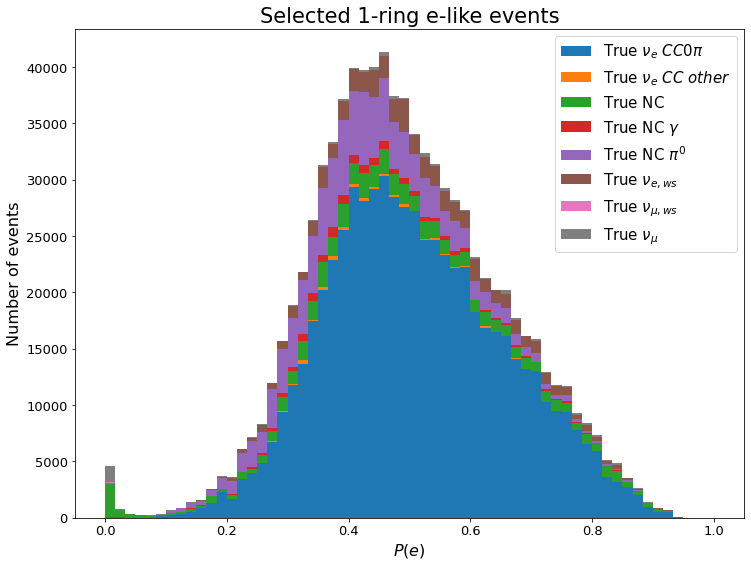

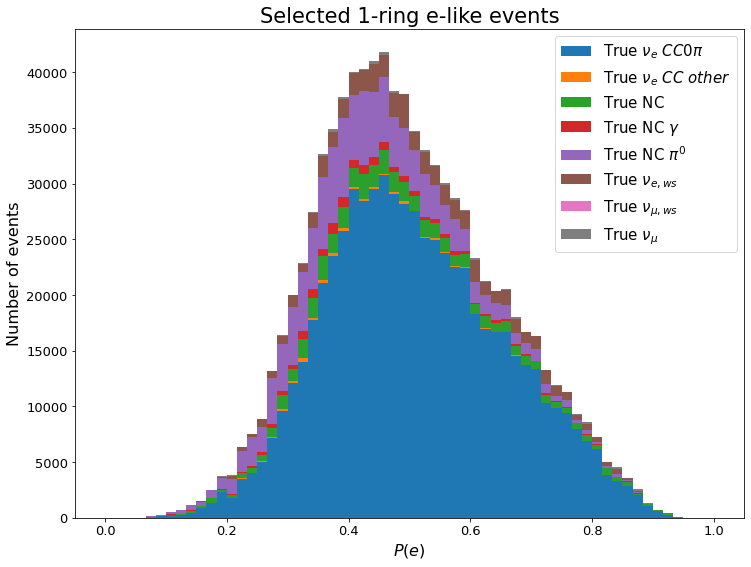

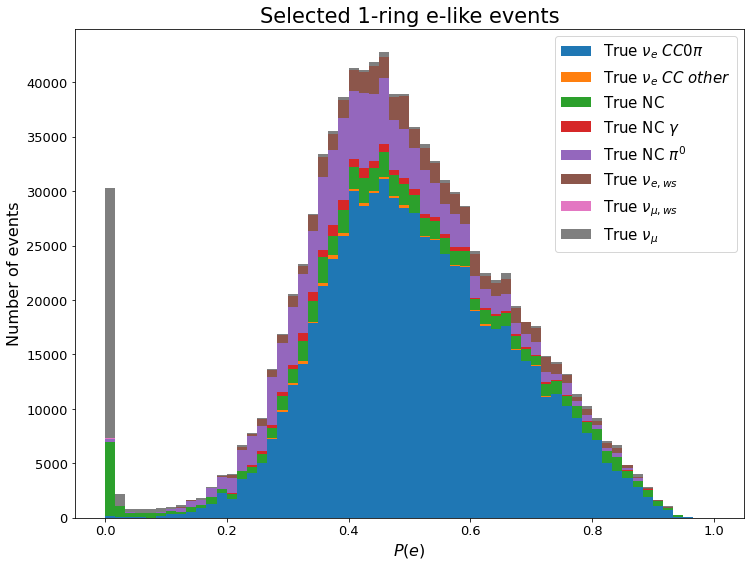

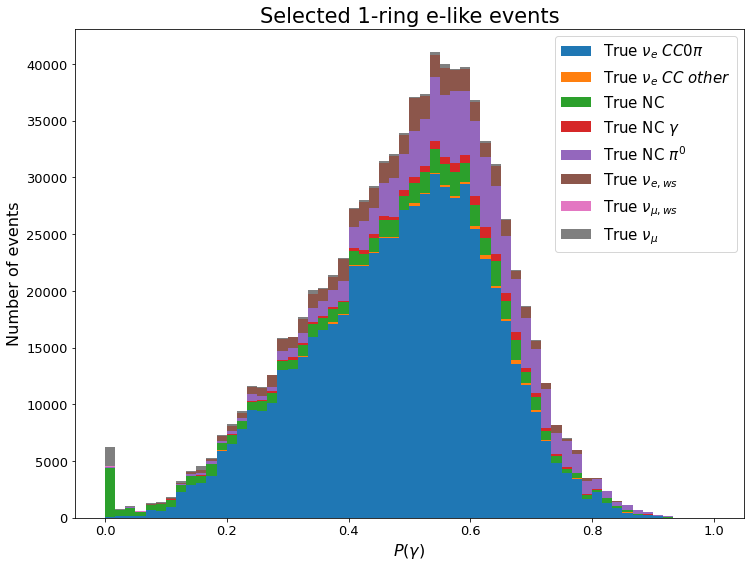

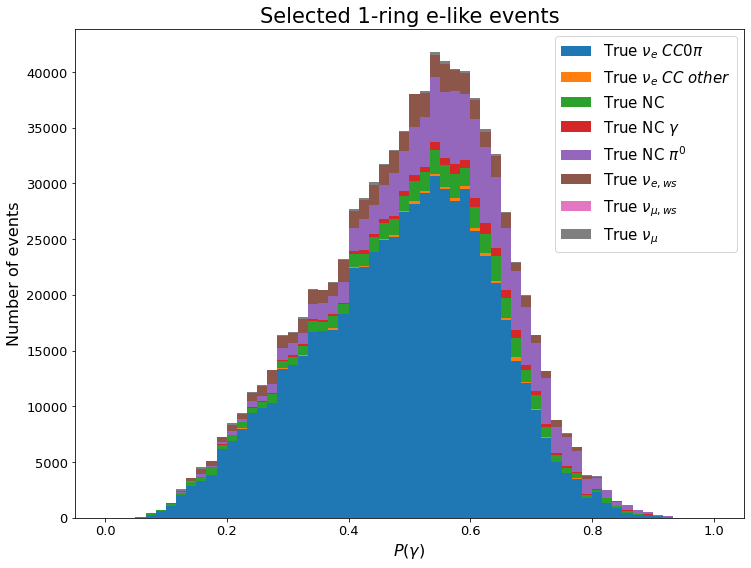

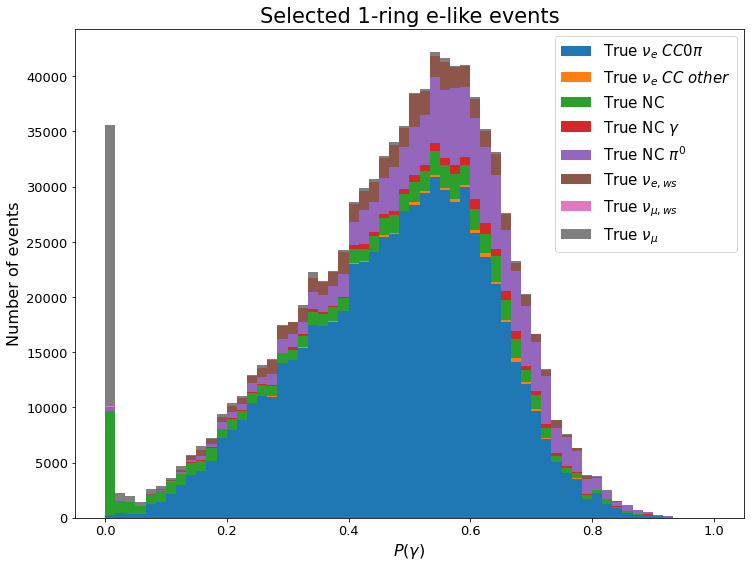

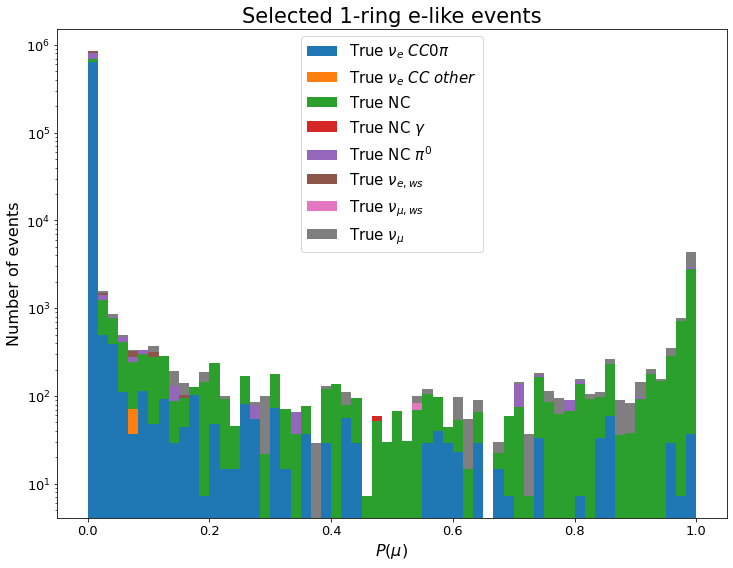

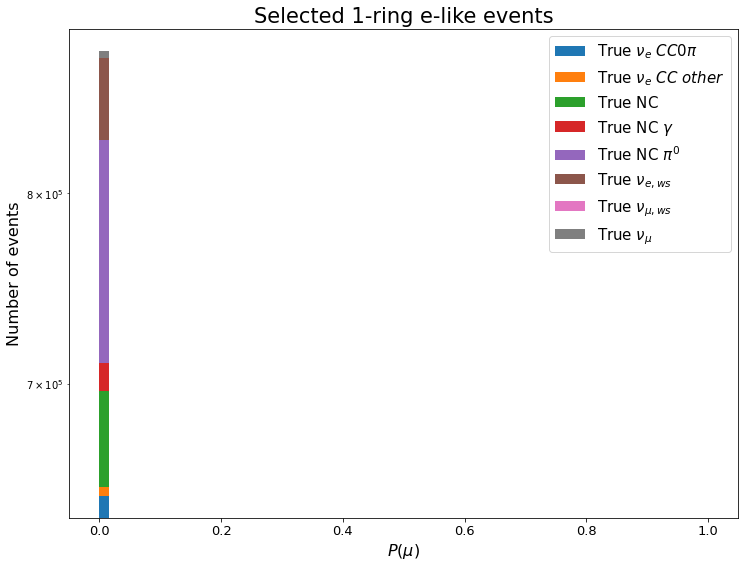

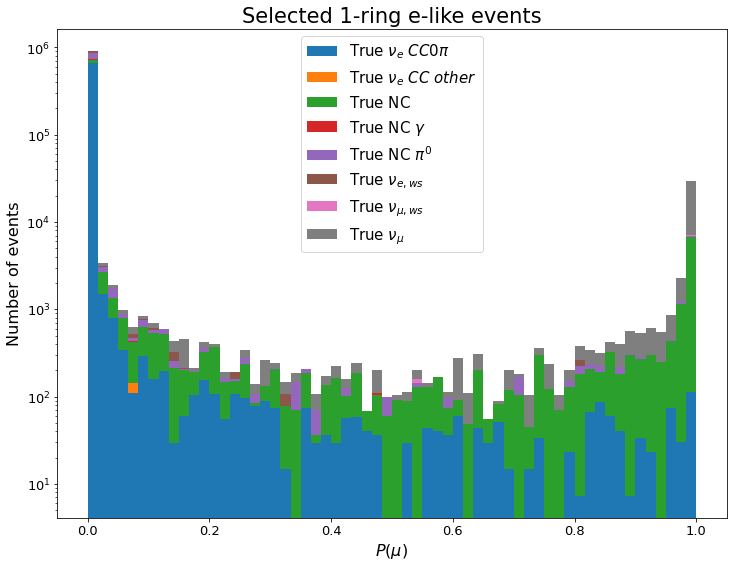

In [4]:
filepath_def = 'histo_root/withcut/p'        # with fiTQun cut
filepath_new= 'histo_root/new_withcut_0.9992/p'     # with Softmax cut
filepath_nocut= 'histo_root/nocut/p'         # withot e/mu cut  
# filepath_nocut= 'histo_root/log_nocut/p'

cut1_integral={}
signal_cut1 = {} 
bg_cut1= {}     
bgnumu_cut1 = {}




cut2_integral={}
signal_cut2 = {} 
bg_cut2= {}    
bgnumu_cut2 = {}


nocut_integral={}
signal_nocut = {} 
bg_nocut= {}    
bgnumu_nocut = {}





for el in ['e', 'gamma', 'mu']:
    print('\n', 'prob', el, '\n')
    
    print('fitquncut')

    cut1_integral[el]= plot_stack_4_for100(el, filepath_def, name = '_fitquncut')
    signal_cut1[el] = cut1_integral[el][0]
    bg_cut1[el] = np.sum(cut1_integral[el])-signal_cut1[el]
    bgnumu_cut1[el]= cut1_integral[el][-1]
    print('Signal: ', signal_cut1[el], 'BG: ', bg_cut1[el], 'BG nu_mu', bgnumu_cut1[el])
    
    print('probcut')

    cut2_integral[el]= plot_stack_4_for100(el, filepath_new, name = '_probcut')
    signal_cut2[el] = cut2_integral[el][0]
    bg_cut2[el] = np.sum(cut2_integral[el])-signal_cut2[el]
    bgnumu_cut2[el]= cut2_integral[el][-1]
    print('Signal: ', signal_cut2[el],'BG: ', bg_cut2[el], 'BG nu_mu', bgnumu_cut2[el])    
    
    print('nocut')

    nocut_integral[el]= plot_stack_4_for100(el, filepath_nocut, name = '_nocut')
    signal_nocut[el] = nocut_integral[el][0]
    bg_nocut[el] = np.sum(nocut_integral[el])-signal_nocut[el]
    bgnumu_nocut[el]= nocut_integral[el][-1]
    print('Signal: ', signal_nocut[el], 'BG: ', bg_nocut[el], 'BG nu_mu', bgnumu_nocut[el])
    
    

In [5]:
el = 'mu'

data = {'Signal Events': [signal_nocut[el], signal_cut1[el], signal_cut2[el]],
        'BG Events': [bg_nocut[el], bg_cut1[el], bg_cut2[el]],
        'Signal Efficiency': [1, signal_cut1[el]/signal_nocut[el], signal_cut2[el]/signal_nocut[el]],
        'BG Rejection': [1, bg_cut1[el]/bg_nocut[el], bg_cut2[el]/bg_nocut[el]],
        'S/BG Ratio': [1, signal_cut1[el]/bg_cut1[el], signal_cut2[el]/bg_cut2[el]],
        r'BG $\nu_{\mu}$ Rejection': [1, bgnumu_cut1[el]/bgnumu_nocut[el], bgnumu_cut2[el]/bgnumu_nocut[el] ],
        'Cuts':[r'no $e/\mu$ cut', 'fiTQun cut', r'$P(\mu)$ cut']
        }


df = pd.DataFrame(data=data)
df = df.set_index('Cuts')
df= df.astype({'Signal Events':int, 'BG Events':int})

df.round({'Signal Efficiency':3, 'BG Rejection':3, 'S/BG Ratio':3, r'BG $\nu_{\mu}$ Rejection':3})

,Signal Events,BG Events,Signal Efficiency,BG Rejection,S/BG Ratio,BG $\nu_{\mu}$ Rejection
Cuts,,,,,,
no $e/\mu$ cut,671695,299238,1.000,1.000,1.000,1.000
fiTQun cut,635742,236776,0.946,0.791,2.685,0.217
$P(\mu)$ cut,647380,236424,0.964,0.790,2.738,0.129


## Final cut log scale over P$(\mu)$

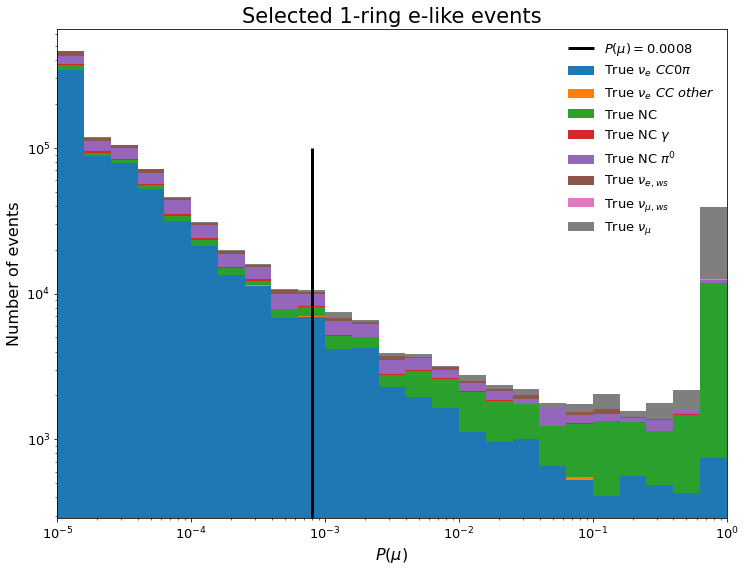

In [6]:
filepath_log_nocut= 'histo_root/log_nocut/p'

lognocut_integral={}

for el in ['mu']:
    lognocut_integral[el]= plot_stack_4_for100(el, filepath_log_nocut, name = '_lognocut_1e-5', log_x=True, underflow_log=True)

883804.6002821922
872518.2345900536
883804.6002821922
872518.2345900536


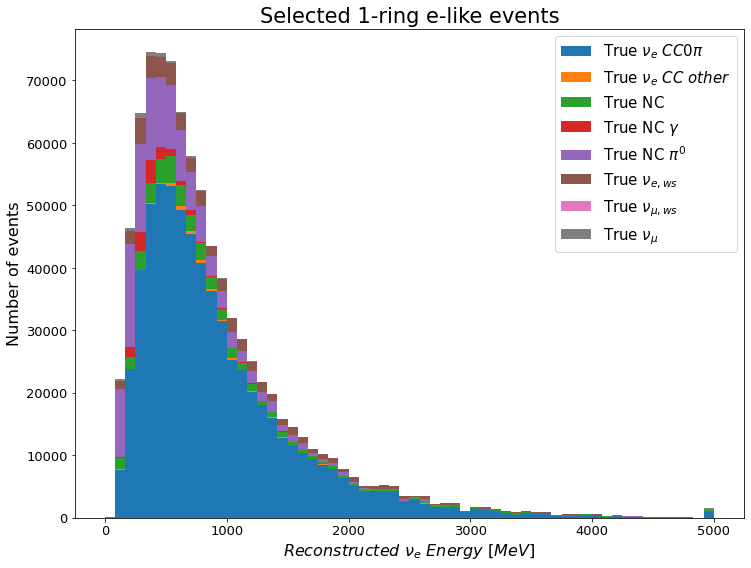

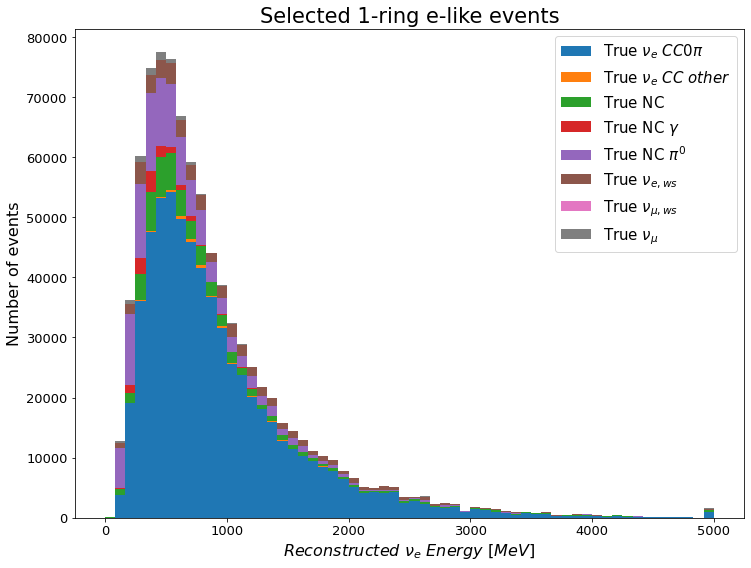

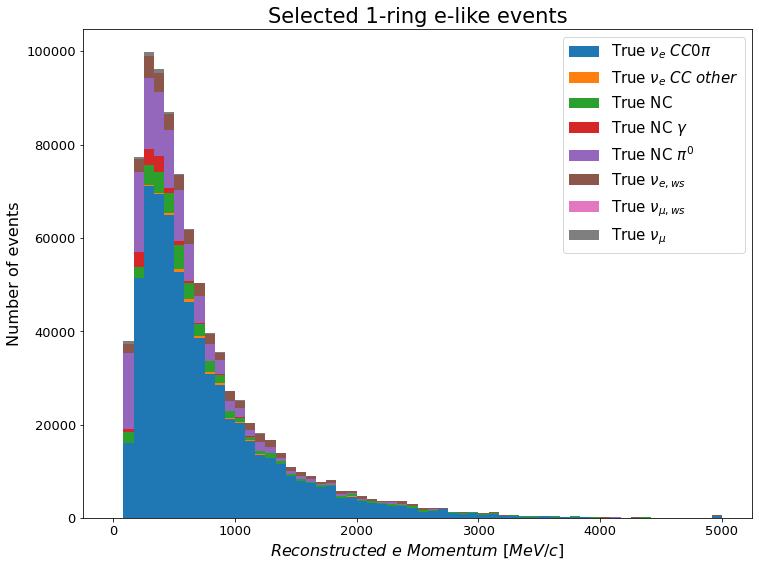

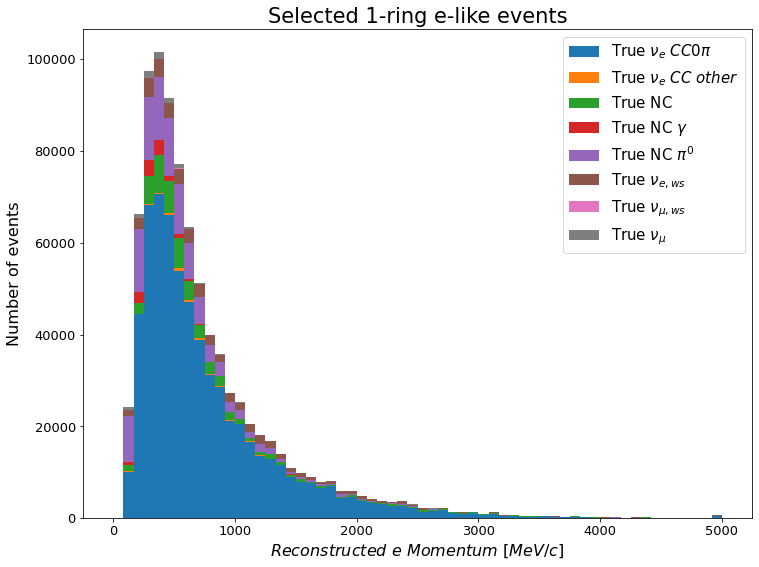

In [7]:
filepath_mycut = 'histo_root/mycut/'
filepath_fitqun = 'histo_root/fitqun/'
intfitqun = {}
intmycut = {}
for value in ['energy', 'momentum']:
# for value in ['energy']:
    intmycut[value] = plot_stack_4_for100(value, filepath_mycut, flow=True, name = '_softmax')
    print(np.sum(intmycut[value]))
    intfitqun[value] = plot_stack_4_for100(value, filepath_fitqun, flow=True, name = '_fitqun')
    print(np.sum(intfitqun[value]))

    fraction = intmycut[value]/intfitqun[value]

In [8]:
latex_legends = [r'True $\nu_{e}~CC0\pi$', r'True $\nu_{e}~CC~other$', r'True NC $~$', r'True NC $\gamma$', r'True NC $\pi^0$', r'True $\nu_{e, ws}$', r'True $\nu_{\mu, ws}$', r'True $\nu_{\mu}$']

df = pd.DataFrame(fraction.reshape(1,8), columns=latex_legends)
df['Fraction']=['Softmax/fiTQun']
df = df.set_index('Fraction')
df.round(3)


,True $\nu_{e}~CC0\pi$,True $\nu_{e}~CC~other$,True NC $~$,True NC $\gamma$,True NC $\pi^0$,"True $\nu_{e, ws}$","True $\nu_{\mu, ws}$",True $\nu_{\mu}$
Fraction,,,,,,,,
Softmax/fiTQun,1.018,0.991,0.812,1.054,1.1,1.035,0.0,0.595


## 2D attempts

In [9]:
def plot_2d(filepath, name, colnorm=False):
    
    rebin_x = 6
    rebin_y = 2
   
    if name=="signal":
        histoname = 'signal_momentum'
        titlename = 'Signal events'
    if name=="background":
        histoname = 'bg_momentum'
        titlename = 'Background events'
    
    for k in range(1,101):
        filename = filepath+'histo_'+str(k)+'.root'
        file = uproot.open(filename)
        data = file[histoname].to_numpy(flow=True)[0]
        
        data_temp = data[:, 1:-1]
        data_temp[:, 0]+=data[:,0]
        data_temp[:, -1]+=data[:,-1]
        data=data_temp
    
        data_temp = data[1:-1, :]
        data_temp[0,:]+=data[0, :]
        data_temp[-1, :]+=data[-1,:]
        data=data_temp

        bins_x = file[histoname].to_numpy()[1] 
        bins_y = file[histoname].to_numpy()[2]
        
        if k==1: 
            data_all=data
            
        else: 
            data_all+=data
 
    
    centers_x = (bins_x[:-1]+np.diff(bins_x)/2).reshape((1, len(bins_x)-1))
    centers_x = rebin(centers_x, rebin_x)
    
    d = np.diff(centers_x)[0,0]
    bins_x = np.concatenate([np.zeros((1,1)), centers_x+d/2], axis=1)
    bins_x = bins_x.reshape(bins_x.shape[1])

    bins_y = rebin_log(bins_y, rebin_y)
    data_all = rebin(data_all.T, rebin_x).T 
    data_all = rebin(data_all, rebin_y)
        
        
    S = np.sum(data_all, axis=1)
    S = S.reshape(data_all.shape[0],1)

    #if wanna normalize for each column separately
    if colnorm: 
        data_all=data_all/S
        normname = '_colnormed'
    else: normname = '_notcolnormed'
    
    
    
    plt.rcParams["figure.figsize"] = (16,12)
    plt.pcolor(
    bins_x, bins_y, data_all.T   #, norm=mpl.colors.LogNorm()
    )
    plt.title(titlename, fontsize = 21)
    plt.xlabel(r'$Reconstructed~{e}~Momentum~[MeV/c]$', fontsize = 16)
    plt.ylabel(r'$P(\mu)$', fontsize = 16)

    plt.colorbar()
    plt.yscale('log')
    plt.ylim(1e-6, 1e0)

    plt.hlines(0.0008, 0, 2500, colors='white', linewidth=3, label='test')
    
    plt.tick_params(axis='x', labelsize=13)    
    plt.tick_params(axis='y', labelsize=13)  
    

#     plt.savefig('images/2D_pmu_'+name+normname+'.png')
#     plt.savefig('images/2D_pmu_'+name+normname+'.pdf')


    plt.show()
    
    return bins_x, bins_y, data_all, centers_x

In [10]:
def plot_ratio(sig_data, bg_data):
    norm = colors.TwoSlopeNorm(vmin=0., vcenter=1., vmax=3)
    data_sbg = sig_data/bg_data
    plt.rcParams["figure.figsize"] = (16,12)

    plt.pcolor(
    bins_x, bins_y, data_sbg.T, norm = norm, cmap = 'RdBu_r'
    #,norm=mpl.colors.LogNorm()
    )
    plt.title("S/BG ratio", fontsize = 21)
    plt.xlabel(r'$Reconstructed~{e}~Momentum~[MeV/c]$', fontsize = 16)
    plt.ylabel(r'$P(\mu)$', fontsize = 16)
    plt.gca().set_facecolor('#90ee90')
    plt.colorbar()
    plt.yscale('log')
    plt.ylim(1e-6, 1e0)
    
    plt.hlines(0.0008, 0, 2500, colors='black', linewidth=3, label='test')

    plt.tick_params(axis='x', labelsize=13)    
    plt.tick_params(axis='y', labelsize=13)  
    
    
#     plt.savefig('images/2D_pmu_SBG.png')
#     plt.savefig('images/2D_pmu_SBG.pdf')
    
    plt.show()

### Momentum with P($\mu$) plots

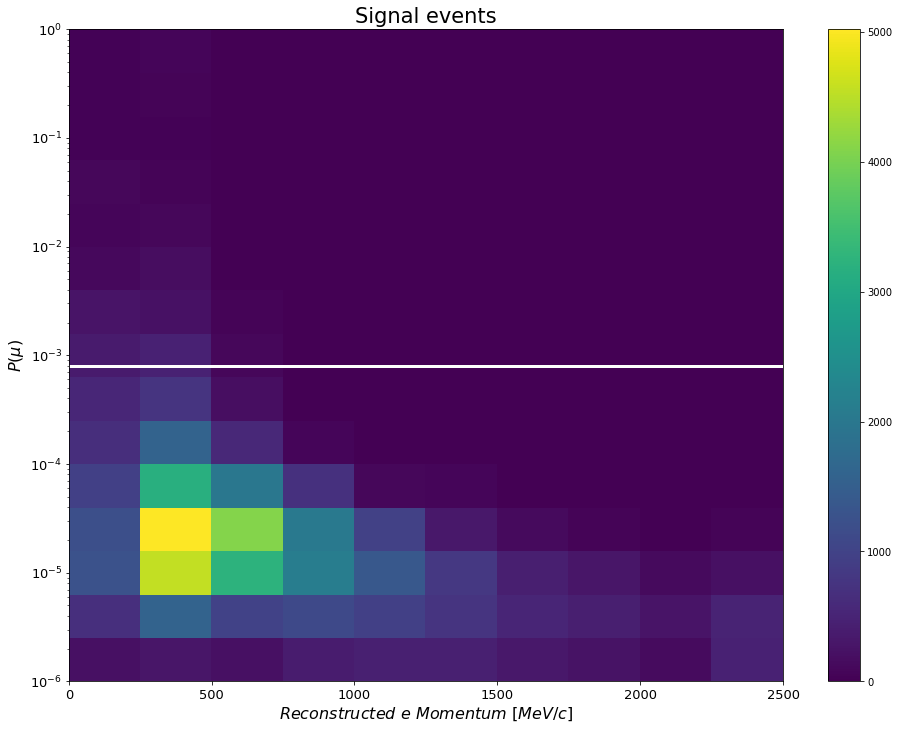

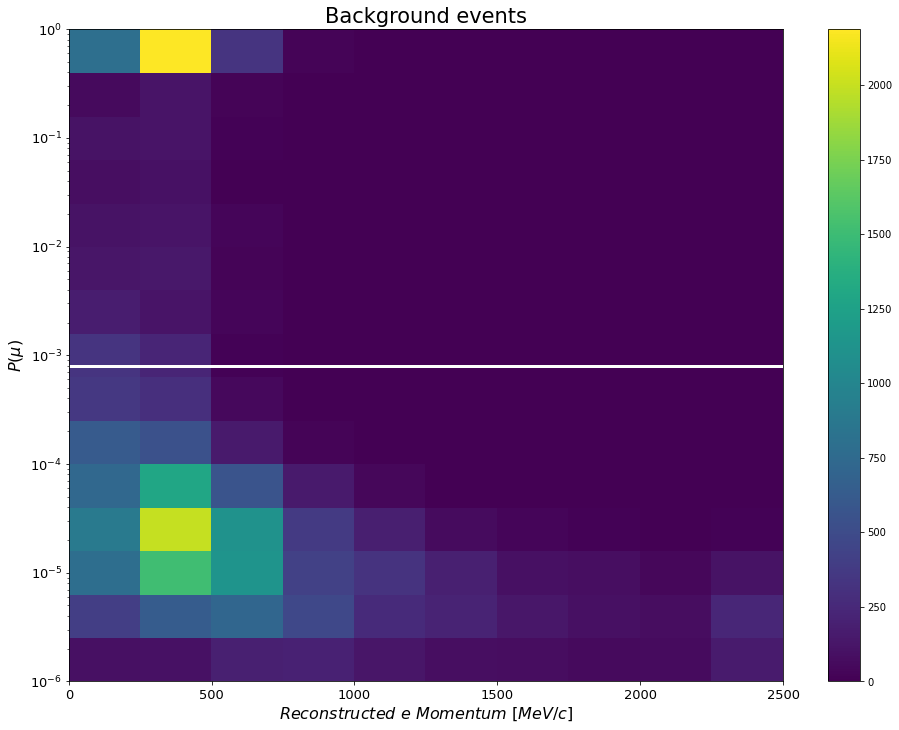

In [11]:
filepath = "histo_root/log_nocut_momentum/"

bins_x, bins_y, sig_data, centers_x = plot_2d(filepath, "signal", colnorm = False)
bins_x, bins_y, bg_data, centers_x = plot_2d(filepath, "background",  colnorm = False)

### Momentum with P($\mu$) plots with each column normalized

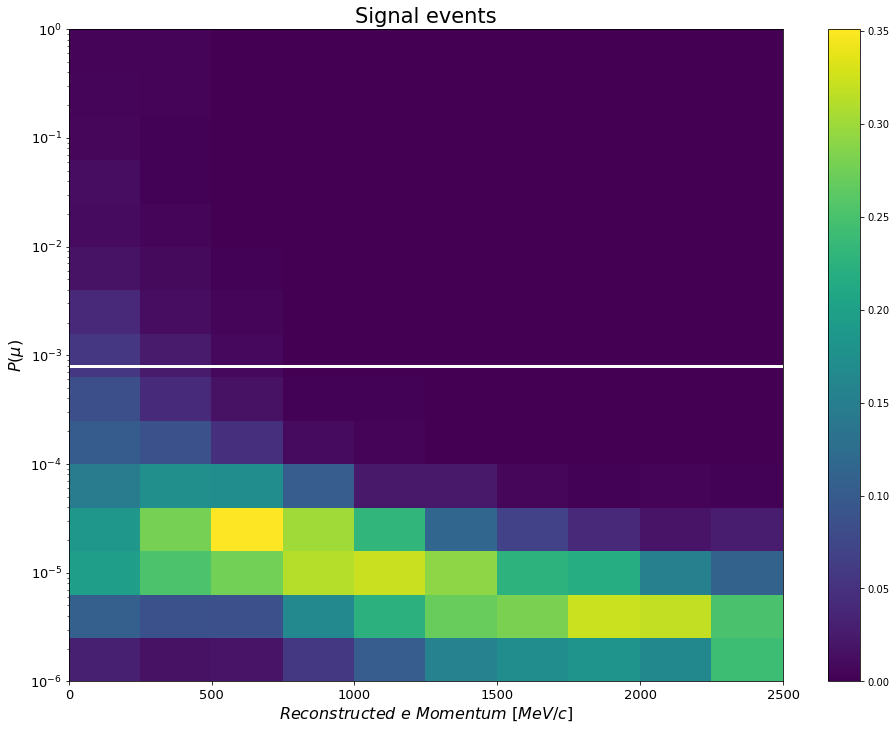

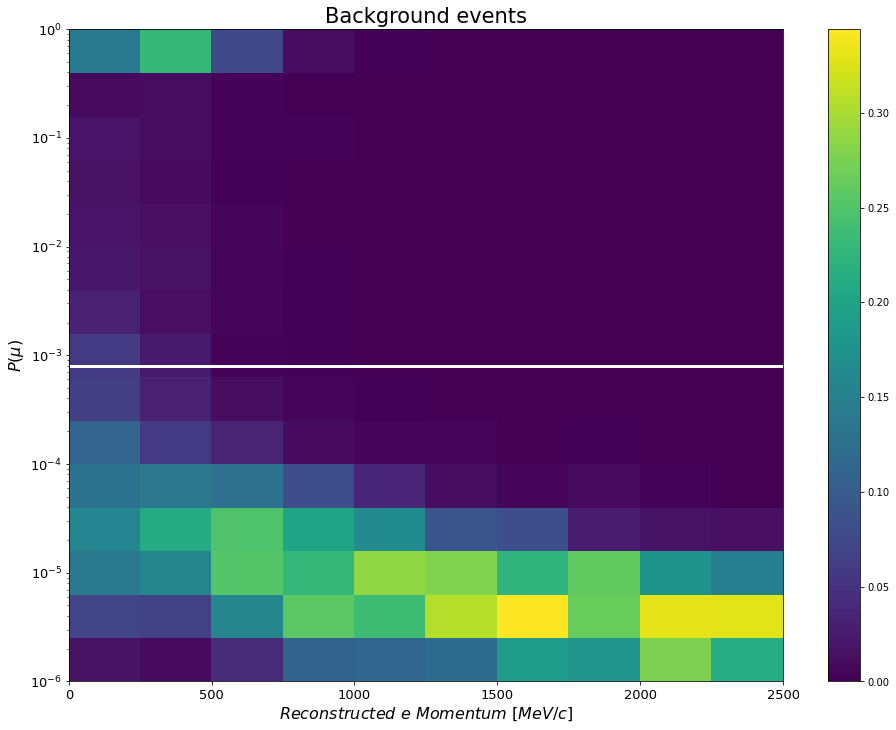

<ipython-input-10-409e739fa472>:3: RuntimeWarning: divide by zero encountered in true_divide
  data_sbg = sig_data/bg_data
<ipython-input-10-409e739fa472>:3: RuntimeWarning: invalid value encountered in true_divide
  data_sbg = sig_data/bg_data


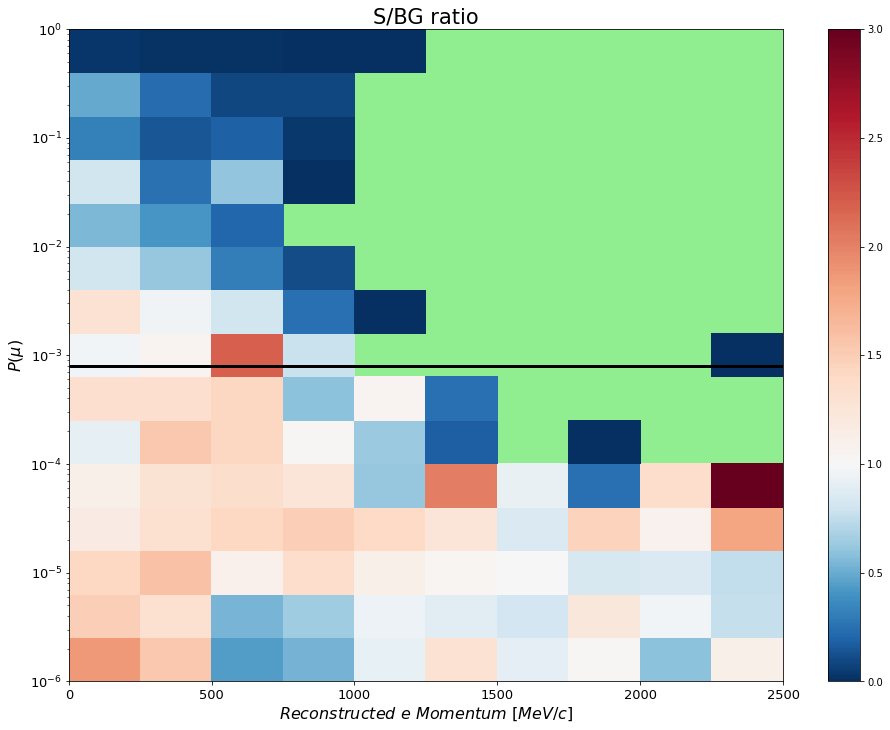

In [12]:
filepath = "histo_root/log_nocut_momentum/"

bins_x, bins_y, sig_data, centers_x = plot_2d(filepath, "signal", colnorm = True)
bins_x, bins_y, bg_data, centers_x = plot_2d(filepath, "background",  colnorm = True)
plot_ratio(sig_data, bg_data)

### Signal and BG means attempt

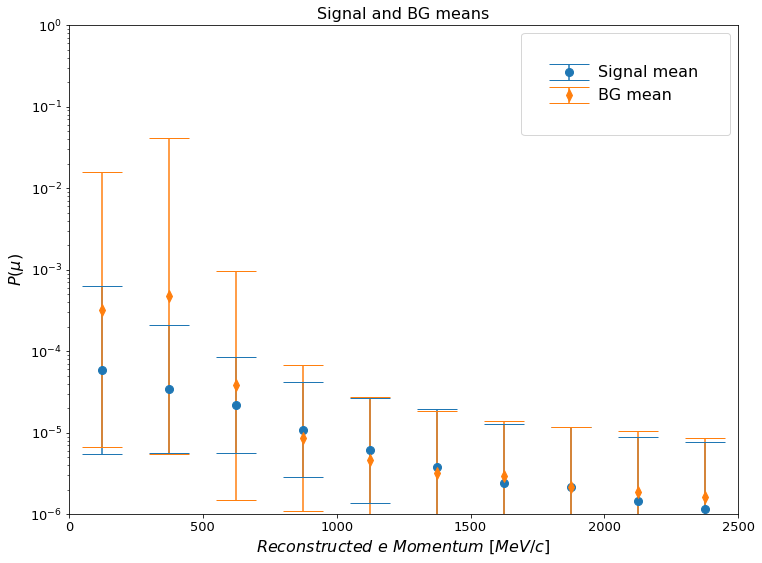

In [13]:
def plot_overlay(centers_x, bins_y, data_array):
    fig, ax = plt.subplots(figsize = (12,9))
    
    count = 0
    for data in data_array:
        logmean, logsigma = log_means(bins_y, data)
        mean = exp10(logmean)
        asymmetric_error = [exp10(logmean)-exp10(logmean-logsigma), exp10(logmean+logsigma)-exp10(logmean)]
        if count==0: fmt = 'o'
        else: fmt = 'd'
            
        ax.errorbar(centers_x, mean, fmt = fmt, yerr=asymmetric_error,  markersize=8, capsize=20)
        count+=1
    ax.set_yscale('log')
    ax.set_ylim(1e-6, 1e0)
    ax.set_xlim(0,2500)
    ax.set_xlabel(r'$Reconstructed~{e}~Momentum~[MeV/c]$', fontsize = 16)
    ax.set_ylabel(r'$P(\mu)$', fontsize = 16)
    
    ax.legend(["Signal mean", "BG mean"], loc='upper right', borderpad=2, fontsize = 16)
    ax.set_title("Signal and BG means", fontsize = 16)
    
    plt.tick_params(axis='x', labelsize=13)    
    plt.tick_params(axis='y', labelsize=13)  
    
    plt.savefig('images/overlay_SBG_means_1e-6.png')
    plt.savefig('images/overlay_SBG_means_1e-6.pdf')
    
    
plot_overlay(centers_x.T, bins_y, [sig_data, bg_data])

## Shape analysis

In [14]:
def plot_shape_and_fraction_both_cuts(class_of_hist, filepathes, rebin_time, name='', normed=True, datashape = (10,60), partitions = 100):
    both_data = [0, 0]
    for i in range(2):
        filepath = filepathes[i]
        
        full_data = np.zeros(datashape)
        for k in range(1, partitions+1):
            filename = filepath+class_of_hist+'/histo_'+str(k)+'.root'                       #momentum

            file = uproot.open(filename)

            legends = [str(key)[:-2] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')]
            data = np.array([file[key].to_numpy(flow=True)[0] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')])
            bins = np.array([file[key].to_numpy()[1] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')])
            centers = bins[:, :-1]+np.diff(bins)/2

            data_temp = data[:, 1:-1]
            data_temp[:, 0]+=data[:,0]
            data_temp[:, -1]+=data[:,-1]

            full_data += data_temp
            
        

        components = len(legends)
        
        #if wanna area normalize
        
        if normed == True:
            normed_data = full_data/np.sum(full_data, axis=1).reshape(full_data.shape[0],1)
            norname = '_normed'
        else:
            normed_data = full_data
            norname = '_notnormed'

            
        normed_data = rebin(normed_data, rebin_time)
        centers = rebin(centers, rebin_time)
        d = np.diff(centers)[:, 0].reshape(components, 1)
        bins = np.concatenate([np.zeros((components,1)), centers+d/2], axis=1)
        
        both_data[i]=normed_data
    

    if class_of_hist=='gamma': xlabel = r'$P(\gamma)$'
    if class_of_hist=='e': xlabel = r'$P(e)$'
    if class_of_hist=='momentum': xlabel = r'$Reconstructed~{e}~Momentum~[MeV/c]$'    
    
    latex_mycut = [r'True $\nu_{e}~CC0\pi~$(Softmax)', r'True $\nu_{e}~CC~other~$(Softmax)', r'True NC $~$(Softmax)', r'True NC $\gamma~$(Softmax)',
                   r'True NC $\pi^0~$(Softmax)', r'True $\nu_{e, ws}~$(Softmax)', r'True $\nu_{\mu, ws}~$(Softmax)', r'True $\nu_{\mu}~$(Softmax)']
    latex_fitqun = [r'True $\nu_{e}~CC0\pi~$(fiTQun)', r'True $\nu_{e}~CC~other~$(fiTQun)', r'True NC $~$(fiTQun)', r'True NC $\gamma~$(fiTQun)',
                    r'True NC $\pi^0~$(fiTQun)', r'True $\nu_{e, ws}~$(fiTQun)', r'True $\nu_{\mu, ws}~$(fiTQun)', r'True $\nu_{\mu}~$(fiTQun)']
    latex_both = [latex_mycut, latex_fitqun]

    latex_ratio = [r'True $\nu_{e}~CC0\pi$', r'True $\nu_{e}~CC~other$', r'True NC $~$', r'True NC $\gamma$', r'True NC $\pi^0$', r'True $\nu_{e, ws}$', r'True $\nu_{\mu, ws}$', r'True $\nu_{\mu}$']

    colors = ['b', 'g', 'r', 'c', 'm', 'y','gray', 'deeppink']

    
    fig, ax = plt.subplots(nrows = 2, ncols =2 , figsize = (24,18))


    for j in range(2):
        if j==0: #mycut
            ls='-'
        if j==1:  #fitqun
            ls=':'

        for component in [0, 2, 4]:
            ax[0,0].hist(
                centers[0], bins=bins[0], weights=both_data[j][component], linestyle = ls, label = latex_both[j][component], 
                histtype = 'step', linewidth=2.5, color=colors[component]        
            )
            
        ax[0,0].legend(loc='upper right', borderpad=1.5, fontsize = 16)
        ax[0,0].set_xlabel(xlabel, fontsize = 16)
        ax[0,0].set_ylabel("Normalized number of events", fontsize = 16)
        ax[0,0].set_xlim(0,2500)



        for component in [1, 3, 5,7]:
            ax[0,1].hist(
                centers[0], bins=bins[0], weights=both_data[j][component], linestyle = ls, label = latex_both[j][component], 
                histtype = 'step', linewidth=2.5, color=colors[component]             
            )
            
        ax[0,1].legend(loc='upper right', borderpad=1.5, fontsize = 16)
        ax[0,1].set_xlabel(xlabel, fontsize = 16)
        ax[0,1].set_ylabel("Normalized number of events", fontsize = 16)
        ax[0,1].set_xlim(0,2500)

    for component in [0, 2, 4]:

        ax[1,0].hist(centers[0], bins=bins[0], weights=both_data[0][component]/both_data[1][component], linestyle = '--', label = latex_ratio[component], 
                histtype = 'step', linewidth=2.5, color=colors[component])
    ax[1,0].legend(loc='upper right', borderpad=1.5, fontsize = 16)
    ax[1,0].set_xlabel(xlabel, fontsize = 16)
    ax[1,0].set_ylabel("Softmax/fiTQun ratio", fontsize = 16)
    ax[1,0].hlines(1, 0, 2500, colors='black', linewidth=3)
    ax[1,0].set_ylim(0.3,1.6) 
    ax[1,0].set_xlim(0, 2500) 




    for component in [1, 3, 5,7]:

        ax[1,1].hist(centers[0], bins=bins[0], weights=both_data[0][component]/both_data[1][component], linestyle = '--', label = latex_ratio[component], 
                histtype = 'step', linewidth=2.5, color=colors[component])
    ax[1,1].legend(loc='upper right', borderpad=1.5, fontsize = 16)
    ax[1,1].set_xlabel(xlabel, fontsize = 16)
    ax[1,1].set_ylabel("Softmax/fiTQun ratio", fontsize = 16)
    ax[1,1].hlines(1, 0, 2500, colors='black', linewidth=3)
    ax[1,1].set_ylim(0.3,1.6) 
    ax[1,1].set_xlim(0, 2500) 


    for c1 in range(2):
        for c2 in range(2):
            ax[c1,c2].set_xlim(0, 2500)
            ax[c1,c2].tick_params(axis='x', labelsize=13) 
            ax[c1,c2].tick_params(axis='y', labelsize=13) 

    
#     plt.savefig('images/unfilled_distr_'+class_of_hist+'_all.png')
#     plt.savefig('images/unfilled_distr_'+class_of_hist+'_all.pdf')



<ipython-input-14-bc9cae2d8e2d>:95: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].hist(centers[0], bins=bins[0], weights=both_data[0][component]/both_data[1][component], linestyle = '--', label = latex_ratio[component],
<ipython-input-14-bc9cae2d8e2d>:109: RuntimeWarning: invalid value encountered in true_divide
  ax[1,1].hist(centers[0], bins=bins[0], weights=both_data[0][component]/both_data[1][component], linestyle = '--', label = latex_ratio[component],
<ipython-input-14-bc9cae2d8e2d>:109: RuntimeWarning: invalid value encountered in true_divide
  ax[1,1].hist(centers[0], bins=bins[0], weights=both_data[0][component]/both_data[1][component], linestyle = '--', label = latex_ratio[component],
<ipython-input-14-bc9cae2d8e2d>:109: RuntimeWarning: invalid value encountered in true_divide
  ax[1,1].hist(centers[0], bins=bins[0], weights=both_data[0][component]/both_data[1][component], linestyle = '--', label = latex_ratio[component],


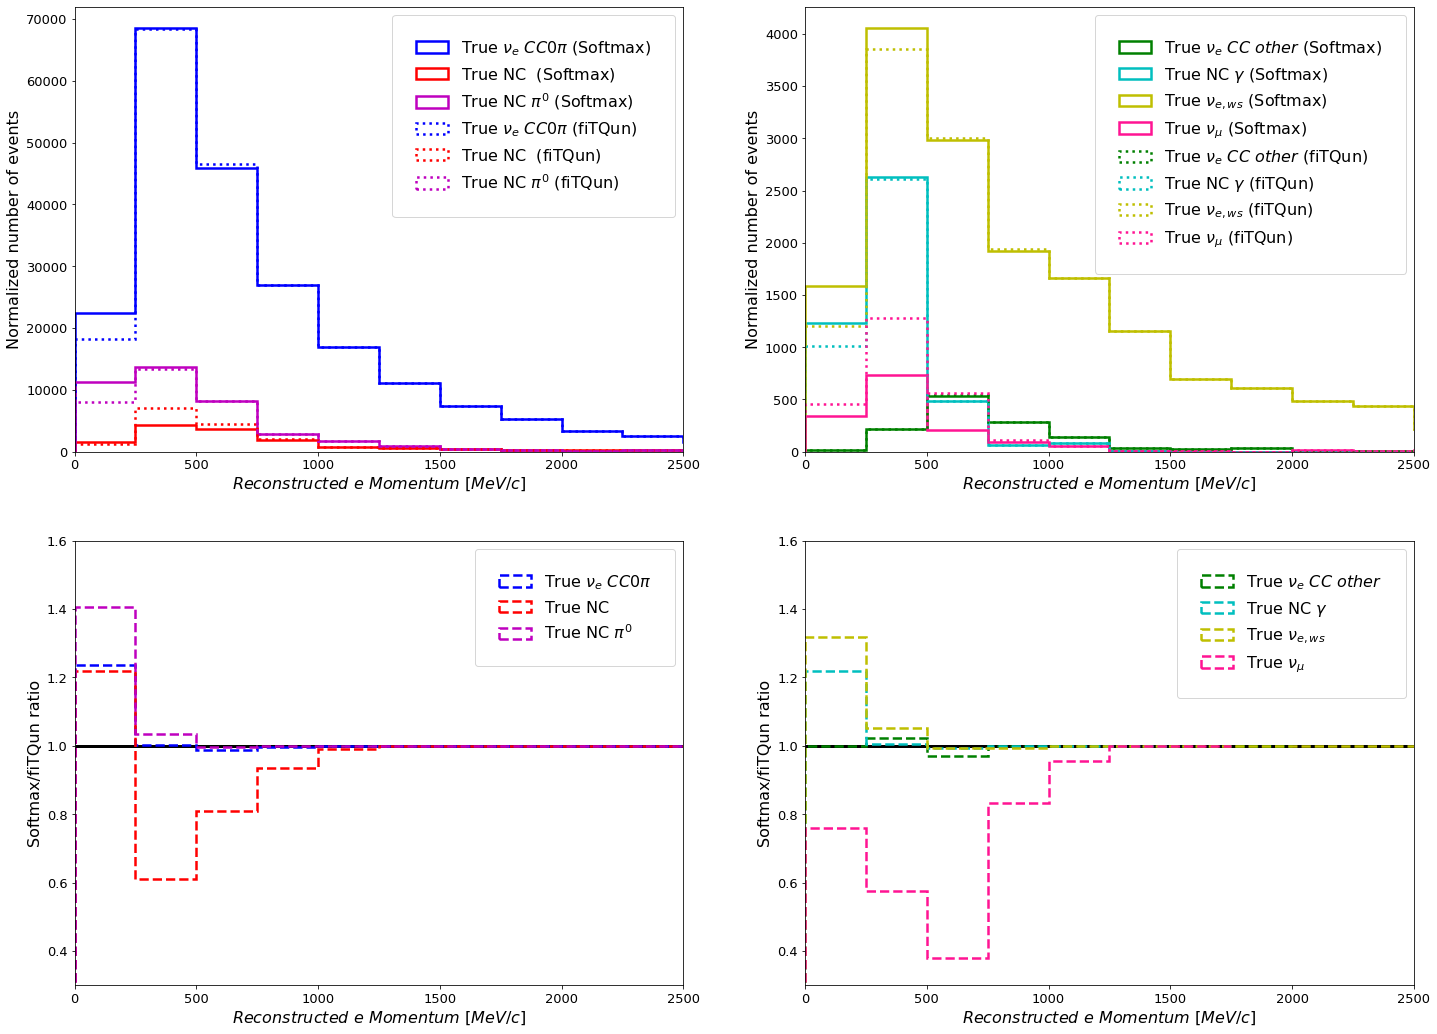

In [15]:
filepath_mycut = 'histo_root/mycut/'
filepath_fitqun = 'histo_root/fitqun/'
intfitqun = {}
intmycut = {}
for value in ['momentum']:
    intmycut[value] = plot_shape_and_fraction_both_cuts(value, [filepath_mycut, filepath_fitqun], 3, name = '_softmax', normed=False)

### NC and Signal separation, area normalized shapes 

In [16]:
def plot_shape_components(class_of_hist, filepath, rebin_time, datashape = (10,60), partitions = 100):
    full_data = np.zeros(datashape)
    for k in range(1, partitions+1):
        filename = filepath+class_of_hist+'/histo_p'+class_of_hist+'_'+str(k)+'.root'

        file = uproot.open(filename)
        
        legends = [str(key)[:-2] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')]
        data = np.array([file[key].to_numpy(flow=True)[0] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')])
        bins = np.array([file[key].to_numpy()[1] for key in file.keys() if key not in ('purity_enu;1', 'efficiency_enu;1', 'selected_events;1')])
        centers = bins[:, :-1]+np.diff(bins)/2

        data_temp = data[:, 1:-1]
        data_temp[:, 0]+=data[:,0]
        data_temp[:, -1]+=data[:,-1]

        full_data += data_temp
        

    components = len(legends)
    
    normed_data = full_data/np.sum(full_data, axis=1).reshape(full_data.shape[0],1)
    
    
    normed_data = rebin(normed_data, rebin_time)
    centers = rebin(centers, rebin_time)
    d = np.diff(centers)[:, 0].reshape(components, 1)
    bins = np.concatenate([np.zeros((components,1)), centers+d/2], axis=1)

    
    
    
    if class_of_hist=='gamma': xlabel = r'$P(\gamma)$'
    if class_of_hist=='e': xlabel = r'$P(e)$'

    fig, ax = plt.subplots(figsize = (12,9))

    for component in [0, 3, 4]: #significant components
#     for component in [0, 1,2,5,7]: #other
        ax.hist(centers[0], bins=bins[0], weights=normed_data[component], label = latex_legends[component], histtype = 'step', linewidth=1.5)
    ax.legend(loc='upper left', borderpad=1.5, fontsize = 16)
    ax.set_title("Selected 1-ring e-like events",  fontsize = 21)
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel("Normalized number of events", fontsize = 16)




#     plt.savefig('images/unfilled_p_'+class_of_hist+'_ML.png')
#     plt.savefig('images/unfilled_p_'+class_of_hist+'_ML.pdf')
        
#     plt.savefig('images/unfilled_p_'+class_of_hist+'_other.png')
#     plt.savefig('images/unfilled_p_'+class_of_hist+'_other.pdf')
    
    
    plt.tick_params(axis='x', labelsize=13)    
    plt.tick_params(axis='y', labelsize=13)  



<ipython-input-16-d2cf7a394ed6>:22: RuntimeWarning: invalid value encountered in true_divide
  normed_data = full_data/np.sum(full_data, axis=1).reshape(full_data.shape[0],1)
<ipython-input-16-d2cf7a394ed6>:22: RuntimeWarning: invalid value encountered in true_divide
  normed_data = full_data/np.sum(full_data, axis=1).reshape(full_data.shape[0],1)


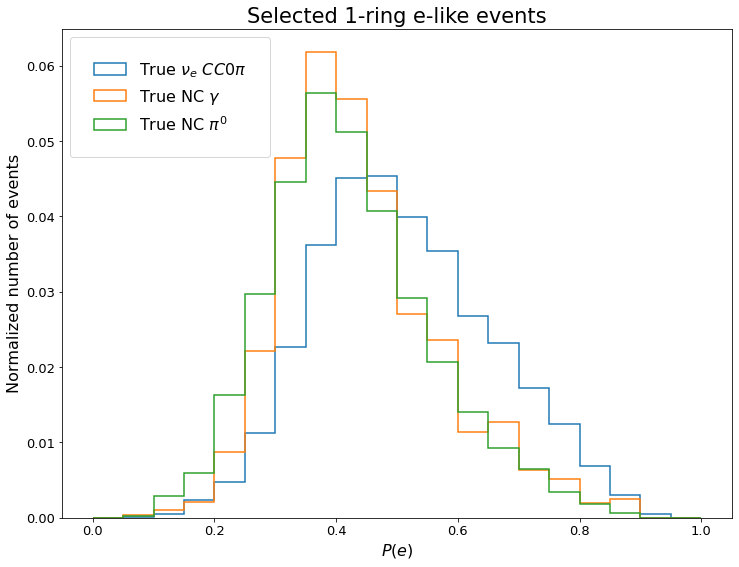

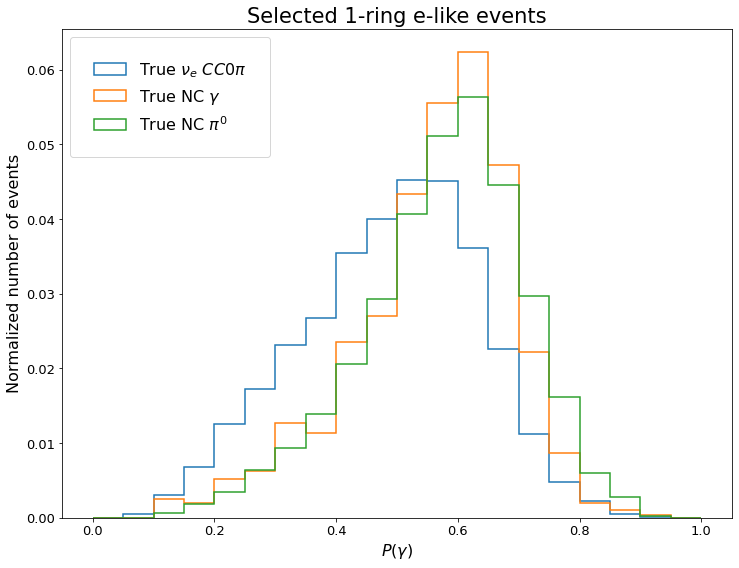

In [17]:
filepath = 'histo_root/new_withcut_0.9992/p'
for el in ['e','gamma']:
    plot_shape_components(el, filepath, 3)
    